# 8: Conditional Manatees

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
%cd "C:/msys64/home/ecotner/statistical-rethinking/"

C:\msys64\home\ecotner\statistical-rethinking


In [127]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyro
from pyro.distributions import Normal, LogNormal, Uniform, Exponential
import torch
import torch.tensor as tt

sys.path.insert(0, "C:/msys64/home/ecotner/statistical-rethinking/code/")
from models import RegressionBase
from utils import sample_posterior, sample_prior, precis, WAIC, HPDI

### Code 8.1
Prepare the terrain ruggedness in Africa dataset

In [8]:
rugged_df = pd.read_csv("data/rugged.csv", sep=";")
rugged_df.sample(5)

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
201,TCD,148,Chad,0.419,0.197,1.135,0.112,3.605,125920.0,15.365,...,0,0,1,529000.0,5.581,8.876,1.879,2.026,776187.0,0.000
212,TUV,798,Tuvalu,0.025,0.020,0.055,0.008,0.000,3.0,-7.414,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
27,BOL,68,Bolivia,0.853,0.911,2.343,0.258,13.570,108438.0,-16.710,...,0,0,0,0.0,NaN,NaN,NaN,NaN,829897.0,26.732
170,PRT,620,Portugal,1.304,0.967,3.937,0.369,15.522,9150.0,39.593,...,0,0,0,0.0,NaN,NaN,NaN,NaN,900000.0,98.270
62,ESH,732,Western Sahara,0.203,0.301,0.565,0.057,0.202,26600.0,24.674,...,0,0,0,0.0,4.932,12.435,2.049,5.215,2439.0,NaN


In [40]:
# make log version of outcome
rugged_df["log_gdp"] = np.log(rugged_df["rgdppc_2000"])
# extract countries with GDP data
dd = rugged_df[~rugged_df["rgdppc_2000"].isna()].copy()
# rescale variables
dd["log_gdp_std"] = dd["log_gdp"]/dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"]/dd["rugged"].max()
# split countries into africa and non-africa
dA1 = dd[dd["cont_africa"] == 1]
dA0 = dd[dd["cont_africa"] == 0]

In [43]:
dA0["log_gdp_std"].mean()

1.0489963244735097

### Code 8.2 - 8.6
Let's create two simple models that consider the African and non-African data separately.

In [44]:
class M8_1(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(1., 1.))
        b = pyro.sample("b", Normal(0., 1.))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            mu = a + b*(self.rugged_std - 0.215)
            pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            mu = a + b*(data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))

m8_1 = M8_1(dA1[["rugged_std", "log_gdp_std"]])

Let's take a look at what the prior thinks are good regression lines

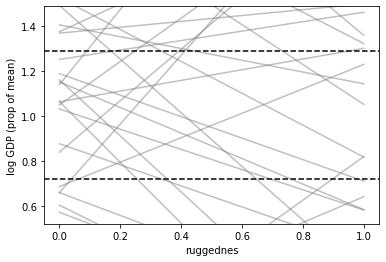

In [46]:
samples = sample_prior(m8_1, 50, ("a", "b"))
x = np.linspace(0, 1, 10)
for a, b in zip(*[samples[k] for k in ("a", "b")]):
    y = a + b*(x - 0.215)
    plt.plot(x, y, color="gray", alpha=0.5)
ymax = dd["log_gdp_std"].max()
ymin = dd["log_gdp_std"].min()
plt.axhline(ymax, color="black", linestyle="--")
plt.axhline(ymin, color="black", linestyle="--")
plt.ylim(top=ymax+0.2, bottom=ymin-0.2)
plt.xlabel("ruggednes")
plt.ylabel("log GDP (prop of mean)")
plt.show()

This looks like shit. Most of the lines predict GDP values outside the observed extemities (horizontal dashed lines). Let's tighten up the priors to make a more realistic prediction.

In [47]:
# A resonable extreme slope might be |b| ~ 0.6; what
# fraction of samples are more extreme than this?
sum(abs(samples["b"]) > 0.6) / len(samples["b"])

0.38

In [50]:
class M8_1(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1))
        b = pyro.sample("b", Normal(0., 0.3))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            mu = a + b*(self.rugged_std - 0.215)
            pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            mu = a + b*(data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))

m8_1 = M8_1(dA1[["rugged_std", "log_gdp_std"]])

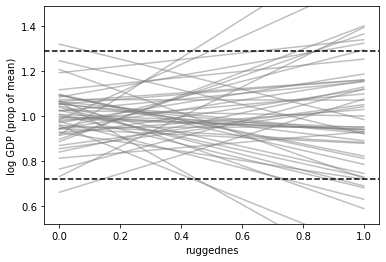

In [51]:
samples = sample_prior(m8_1, 50, ("a", "b"))
x = np.linspace(0, 1, 10)
for a, b in zip(*[samples[k] for k in ("a", "b")]):
    y = a + b*(x - 0.215)
    plt.plot(x, y, color="gray", alpha=0.5)
ymax = dd["log_gdp_std"].max()
ymin = dd["log_gdp_std"].min()
plt.axhline(ymax, color="black", linestyle="--")
plt.axhline(ymin, color="black", linestyle="--")
plt.ylim(top=ymax+0.2, bottom=ymin-0.2)
plt.xlabel("ruggednes")
plt.ylabel("log GDP (prop of mean)")
plt.show()

In [53]:
m8_1.train(1000)
samples = sample_posterior(m8_1, 1000, ("a", "b", "sigma"))
precis(samples, 0.89)

,mean,stddev,5.5%,94.5%
a,0.880813,0.0169905,0.852815,0.907579
b,0.136769,0.082763,-0.000943387,0.266177
sigma,0.111312,0.0124817,0.0927601,0.13317


In [54]:
m8_2 = M8_1(dA0[["rugged_std", "log_gdp_std"]])
m8_2.train(1000)
samples = sample_posterior(m8_2, 1000, ("a", "b", "sigma"))
precis(samples, 0.89)

,mean,stddev,5.5%,94.5%
a,1.05155,0.0116359,1.03241,1.07006
b,-0.148446,0.0569273,-0.240807,-0.0567192
sigma,0.112877,0.00754983,0.101425,0.124681


### Code 8.7 - 8.12
Now let's try and figure out a way to include all the data in the same model rather than breaking it up into different datasets. First we will try making the intercept depend on the Africa 0/1 indicator. Specifically, we want to create two different intercepts like $\mu_i = \alpha[A_i] + \beta (r_i - \bar{r})$, instead of the typical $\mu_i = \alpha + \beta (r_i - \bar{r}) + \gamma A_i$, which will naturally lead to higher uncertainty for African nations since $\mu_i$ depends on 3 random variables rather than 2 for that subset of data.

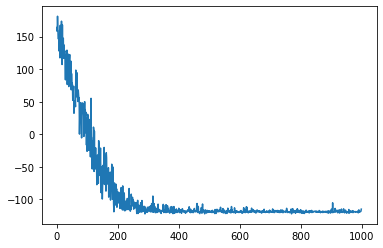

In [108]:
class M8_4(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(0))
        b = pyro.sample("b", Normal(0., 0.3))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            mu = a[self.cont_africa] + b * (self.rugged_std - 0.215)
            pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            mu = a[data["cont_africa"]] + b * (data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))
            
m8_4 = M8_4(dd[["log_gdp_std", "rugged_std", "cont_africa"]], categoricals=("cont_africa",))
loss = m8_4.train(1000)
plt.plot(loss); plt.show()

Let's extract some samples and WAIC so that we can compare with other models.

In [109]:
samples = {"m8.4": sample_posterior(m8_4, 1000, ("a", "b", "sigma"))}
x = {k: getattr(m8_4, k) for k in ("log_gdp_std", "cont_africa", "rugged_std")}
waic = {"m8.4": WAIC(m8_4, x, x["log_gdp_std"], "log_gdp_std", 1000)}

Now to compare with the original linear model (without the Africa indicator), but trained on all the data

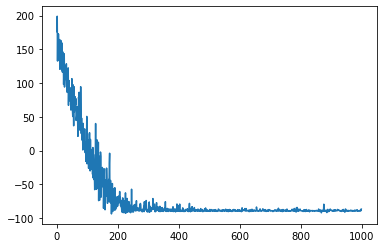

In [110]:
m8_3 = M8_1(dd[["log_gdp_std", "rugged_std"]])
loss = m8_3.train(1000)
plt.plot(loss); plt.show()

In [111]:
samples["m8.3"] = sample_posterior(m8_3, 1000, ("a", "b", "sigma"))
x = {k: getattr(m8_3, k) for k in ("log_gdp_std", "rugged_std")}
waic["m8.3"] = WAIC(m8_3, x, x["log_gdp_std"], "log_gdp_std", 1000)

In [118]:
waic_df = pd.DataFrame([
    {
        "WAIC": v.sum().item(),
        "SE": torch.sqrt(len(v)*v.var()).item(),
    } for k, v in waic.items()
], index=waic.keys())
m = waic_df.index[waic_df["WAIC"].argmin()]
for nm in waic_df.index:
    waic_df.loc[nm, "dWAIC"] = waic_df.loc[nm, "WAIC"] - waic_df.loc[m, "WAIC"]
    waic_df.loc[nm, "dSE"] = torch.sqrt(len(dd)*(waic[nm] - waic[m]).var()).item()
waic_df.sort_values("WAIC")

,WAIC,SE,dWAIC,dSE
m8.4,-249.873779,14.454859,0.000000,0.000000
m8.3,-187.733917,12.404519,62.139862,12.927387


In [124]:
s = samples["m8.4"].copy()
for i in range(2):
    s[f"a[{i}]"] = s["a"][:,i]
del s["a"]
precis(s, 0.89)

,mean,stddev,5.5%,94.5%
b,-0.0657412,0.0442287,-0.138408,0.0053706
sigma,0.11456,0.00739068,0.102907,0.126851
a[0],1.03972,0.00995688,1.02368,1.05601
a[1],0.888853,0.0168037,0.862096,0.914934


In [126]:
precis(samples["m8.3"], 0.89)

,mean,stddev,5.5%,94.5%
a,1.00079,0.0115922,0.982346,1.01994
b,0.0321427,0.0571254,-0.0553987,0.12095
sigma,0.14099,0.00828221,0.128144,0.154354


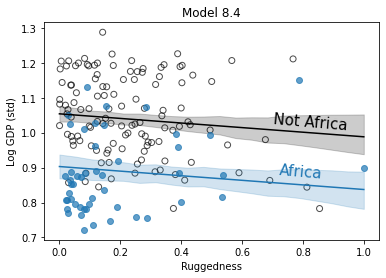

In [162]:
x = np.linspace(0, 1, 20)
s = samples["m8.4"]
for A, c in zip((0, 1), ("black", "C0")):
    # Sample mu
    mu = s["a"][:,A][:,None] + s["b"][:,None] * (x[None,:] - 0.215)
    # Calculate mean/HPDI
    mean = mu.mean(axis=0)
    hpdi = np.stack([HPDI(_s, 0.89) for _s in mu.T]).T
    # Plot regression lines
    plt.plot(x, mean, color=c)
    plt.fill_between(x, *hpdi, alpha=0.2, color=c)
    # Plot data
    _d = dd[dd["cont_africa"]==A]
    fc = "C0" if A else "none"
    plt.scatter(_d["rugged_std"], _d["log_gdp_std"], edgecolor=c, facecolor=fc, alpha=0.7)
plt.xlabel("Ruggedness")
plt.ylabel("Log GDP (std)")
plt.text(0.7, 1.01, "Not Africa", rotation=-4.9, fontsize=15)
plt.text(0.72, 0.87, "Africa", rotation=-4.9, fontsize=15, color="C0")
plt.title("Model 8.4")
plt.show()

### Code 8.13 - 8.18
Now we want to introduce an "interaction effect". The above plot shows that model 8.4 does capture the different means of African and non-African nations, but it cannot capture the difference in slope. To do that, we'll have to generalize our model so that the $\beta$ parameter depends on $A_i$:
$$\mu_i = \alpha[A_i] + \beta[A_i] (r_i - \bar{r})$$

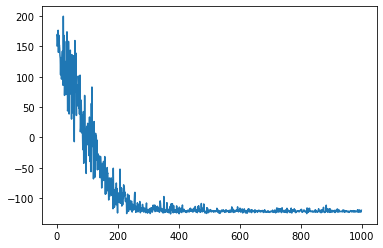

In [149]:
class M8_5(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(0))
        b = pyro.sample("b", Normal(0., 0.3).expand([2]).to_event(0))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            A = self.cont_africa
            mu = a[A] + b[A] * (self.rugged_std - 0.215)
            pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            A = data["cont_africa"]
            mu = a[A] + b[A] * (data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))
            
m8_5 = M8_5(dd[["log_gdp_std", "rugged_std", "cont_africa"]], categoricals=("cont_africa",))
loss = m8_5.train(1000)
plt.plot(loss); plt.show()

In [151]:
samples["m8.5"] = sample_posterior(m8_5, 1000, ("a", "b", "sigma"))
x = {k: getattr(m8_5, k) for k in ("log_gdp_std", "rugged_std", "cont_africa")}
waic["m8.5"] = WAIC(m8_5, x, x["log_gdp_std"], "log_gdp_std", 1000)

In [154]:
s = samples["m8.5"].copy()
for i in (1, 2):
    s[f"a[{i}]"] = s["a"][:,i-1]
    s[f"b[{i}]"] = s["b"][:,i-1]
del s["a"], s["b"]
precis(s, 0.89)

,mean,stddev,5.5%,94.5%
sigma,0.112911,0.00736997,0.100888,0.124436
a[1],1.0519,0.0101534,1.03534,1.06791
b[1],-0.154265,0.0553744,-0.243801,-0.0673127
a[2],0.886373,0.0185256,0.858131,0.916085
b[2],0.138013,0.0780621,0.0137933,0.261873


In [164]:
waic_df = pd.DataFrame([
    {
        "WAIC": v.sum().item(),
        "SE": torch.sqrt(len(v)*v.var()).item(),
    } for k, v in waic.items()
], index=waic.keys())
m = waic_df.index[waic_df["WAIC"].argmin()]
for nm in waic_df.index:
    waic_df.loc[nm, "dWAIC"] = waic_df.loc[nm, "WAIC"] - waic_df.loc[m, "WAIC"]
    waic_df.loc[nm, "dSE"] = torch.sqrt(len(dd)*(waic[nm] - waic[m]).var()).item()
waic_df.sort_values("WAIC")

,WAIC,SE,dWAIC,dSE
m8.5,-257.925262,14.564645,0.000000,0.000000
m8.4,-249.873779,14.454859,8.051483,6.833963
m8.3,-187.733917,12.404519,70.191345,14.923897


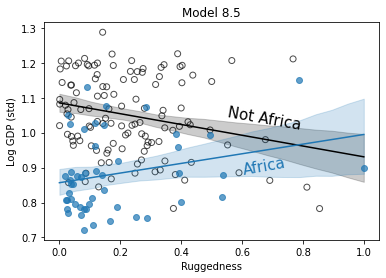

In [163]:
x = np.linspace(0, 1, 20)
s = samples["m8.5"]
for A, c in zip((0, 1), ("black", "C0")):
    # Sample mu
    mu = s["a"][:,A][:,None] + s["b"][:,A][:,None] * (x[None,:] - 0.215)
    # Calculate mean/HPDI
    mean = mu.mean(axis=0)
    hpdi = np.stack([HPDI(_s, 0.89) for _s in mu.T]).T
    # Plot regression lines
    plt.plot(x, mean, color=c)
    plt.fill_between(x, *hpdi, alpha=0.2, color=c)
    # Plot data
    _d = dd[dd["cont_africa"]==A]
    fc = "C0" if A else "none"
    plt.scatter(_d["rugged_std"], _d["log_gdp_std"], edgecolor=c, facecolor=fc, alpha=0.7)
plt.xlabel("Ruggedness")
plt.ylabel("Log GDP (std)")
plt.text(0.55, 1.01, "Not Africa", rotation=-10, fontsize=15)
plt.text(0.6, 0.88, "Africa", rotation=10, fontsize=15, color="C0")
plt.title("Model 8.5")
plt.show()

The typical interpretation is to say that the effect of ruggedness on log GDP depends on whether a country is in Africa or not. However, it is equally correct to say that the effect of being in Africa on log GDP depends on ruggedness. To visualize this, let's create a counter-factual plot showing the difference between two countries in or not in Africa, with the same ruggedness.

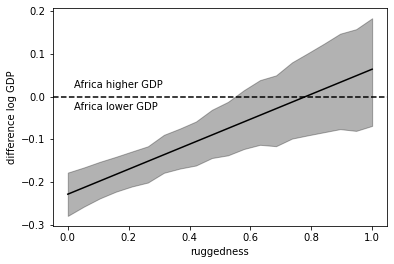

In [172]:
x = np.linspace(0, 1, 20)
s = samples["m8.5"]
mu = s["a"][:,:,None] + s["b"][:,:,None] * (x[None,None,:] - 0.215)
mu = (mu[:,1,:] - mu[:,0,:]).squeeze()
mean = mu.mean(axis=0)
hpdi = np.stack([HPDI(_s, 0.89) for _s in mu.T]).T
plt.plot(x, mean, color="black")
plt.fill_between(x, *hpdi, color="black", alpha=0.3)
plt.axhline(0, color="black", linestyle="--")
plt.text(0.02, 0.02, "Africa higher GDP")
plt.text(0.02, -0.03, "Africa lower GDP")
plt.xlabel("ruggedness")
plt.ylabel("difference log GDP")
plt.show()

### Code 8.19 - 8.24
Now that we have looked at interactions between a categorical and continuous variable (which amounts to having a different continuous variable for each category), what about the interaction between multiple continuous variables?

In [187]:
tulips_df = pd.read_csv("data/tulips.csv", sep=";")
tulips_df.sample(5)

,bed,water,shade,blooms
0,a,1,1,0.00
8,a,3,3,134.95
20,c,1,3,106.75
14,b,2,3,65.48
21,c,2,1,246.00


In [188]:
d = tulips_df.copy()
d["blooms_std"] = d["blooms"]/d["blooms"].max()
d["water_cent"] = d["water"] - d["water"].mean()
d["shade_cent"] = d["shade"] - d["shade"].mean()

First, let's just do a simple non-interacting linear regression for comparison later

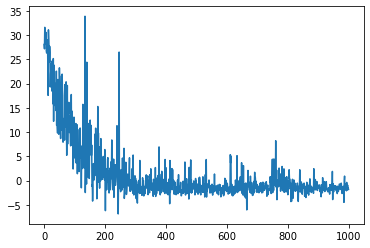

In [197]:
class M8_6(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(0.5, 0.25))
        bw = pyro.sample("bw", Normal(0., 0.25))
        bs = pyro.sample("bs", Normal(0., 0.25))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            mu = a + bw*self.water_cent + bs*self.shade_cent
            pyro.sample("blooms_std", Normal(mu, sigma), obs=self.blooms_std)
        else:
            mu = a + bw*data["water_cent"] + bs*data["shade_cent"]
            return pyro.sample("blooms_std", Normal(mu, sigma))
        
m8_6 = M8_6(d[["blooms_std","water_cent","shade_cent"]])
loss = m8_6.train(1000)
plt.plot(loss); plt.show()

In [198]:
prior = {"m8.6": sample_prior(m8_6, 1000, ("a", "bw", "bs"))}
posterior = {"m8.6": sample_posterior(m8_6, 1000, ("a", "bw", "bs"))}

Now we want to build our interacting model. The slope of the centered water levels $W_i$, should depend on the centered shade levels $S_i$. If we pretend to do a linear regression of the slope of water $\gamma_{w,i}$ on shade, that gives us
$$
\mu_i = \alpha + \gamma_{w,i} W_i + \beta_s S_i \\
\gamma_{w,i} = \beta_w + \beta_{ws} S_i
$$

If we plug the second equation into the first, we arrive at the relation
$$
\mu_i = \alpha + \beta_w W_i \beta_s S_i + \beta_{ws} S_i W_i
$$
which is the same as our previous linear model but with an additional multiplicative term between $W$ and $S$!

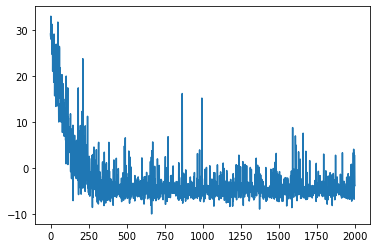

In [199]:
class M8_7(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(0.5, 0.25))
        bw = pyro.sample("bw", Normal(0., 0.25))
        bs = pyro.sample("bs", Normal(0., 0.25))
        bws = pyro.sample("bws", Normal(0., 0.25))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            W, S = self.water_cent, self.shade_cent
            mu = a + bw*W + bs*S + bws*W*S
            pyro.sample("blooms_std", Normal(mu, sigma), obs=self.blooms_std)
        else:
            W, S = data["water_cent"], data["shade_cent"]
            mu = a + bw*W + bs*S + bws*W*S
            return pyro.sample("blooms_std", Normal(mu, sigma))
        
m8_7 = M8_7(d[["blooms_std","water_cent","shade_cent"]])
loss = m8_7.train(2000)
plt.plot(loss); plt.show()

In [200]:
prior["m8.7"] = sample_prior(m8_7, 1000, ("a", "bw", "bs", "bws"))
posterior["m8.7"] = sample_posterior(m8_7, 1000, ("a", "bw", "bs", "bws"))

## Code 8.25 - 8.??
Make a "triptych" plot of two variables vs each other with the third held constant for both the non-interacting and interacting models

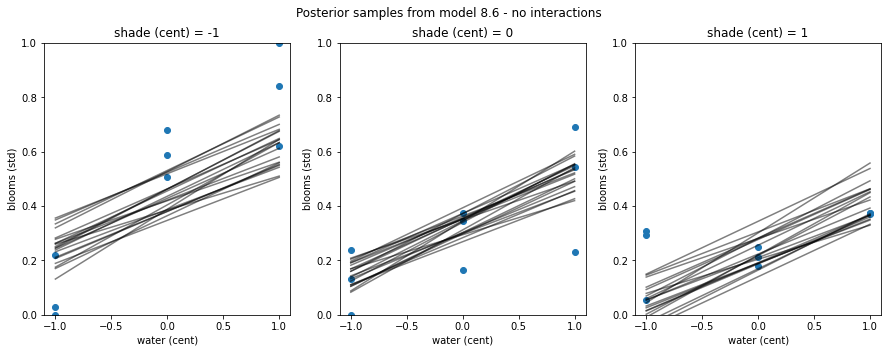

In [213]:
def triptych(samples, model_nm):
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
    N = 20
    W = np.linspace(-1, 1)
    a = samples["a"][:N]
    bw = samples["bw"][:N]
    bs = samples["bs"][:N]
    bws = samples.get("bws", np.zeros(N))
    for S, ax in zip((-1, 0, 1), axes):
        plt.sca(ax)
        for i in range(20):
            mu = a[i] + bw[i]*W + bs[i]*S + bws[i]*W*S
            plt.plot(W, mu, color="black", alpha=0.5)
        _d = d[d["shade_cent"]==S]
        plt.scatter(_d["water_cent"], _d["blooms_std"], color="C0")
        plt.title(f"shade (cent) = {int(S)}")
        plt.xlabel("water (cent)")
        plt.ylabel("blooms (std)")
        plt.ylim(bottom=0, top=1)
    fig.suptitle(f"Posterior samples from model {model_nm}")
        
triptych(posterior["m8.6"], "8.6 - no interactions")

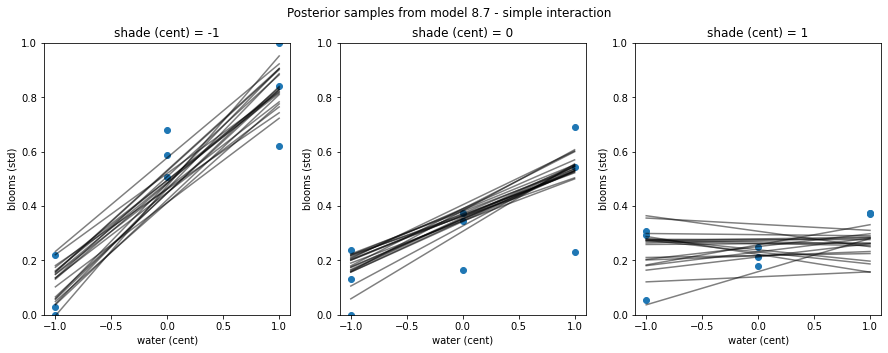

In [214]:
triptych(posterior["m8.7"], "8.7 - simple interaction")

We can see that in the non-interacting model (top), the slope of the water vs blooms regression is the same for all levels of shade. However in the interacting model (bottom), increasing the level of shade decreases the slope.

### Code 8.26
Now let's plot the priors that we set before, see if they're any good.

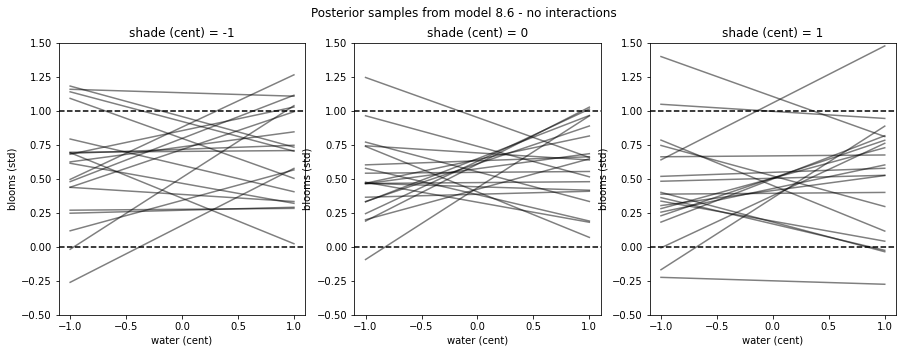

In [216]:
def triptych(samples, model_nm):
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
    N = 20
    W = np.linspace(-1, 1)
    a = samples["a"][:N]
    bw = samples["bw"][:N]
    bs = samples["bs"][:N]
    bws = samples.get("bws", np.zeros(N))
    for S, ax in zip((-1, 0, 1), axes):
        plt.sca(ax)
        for i in range(20):
            mu = a[i] + bw[i]*W + bs[i]*S + bws[i]*W*S
            plt.plot(W, mu, color="black", alpha=0.5)
        plt.axhline(0, color="black", linestyle="--")
        plt.axhline(1, color="black", linestyle="--")
        plt.title(f"shade (cent) = {int(S)}")
        plt.xlabel("water (cent)")
        plt.ylabel("blooms (std)")
        plt.ylim(bottom=-0.5, top=1.5)
    fig.suptitle(f"Posterior samples from model {model_nm}")
        
triptych(prior["m8.6"], "8.6 - no interactions")

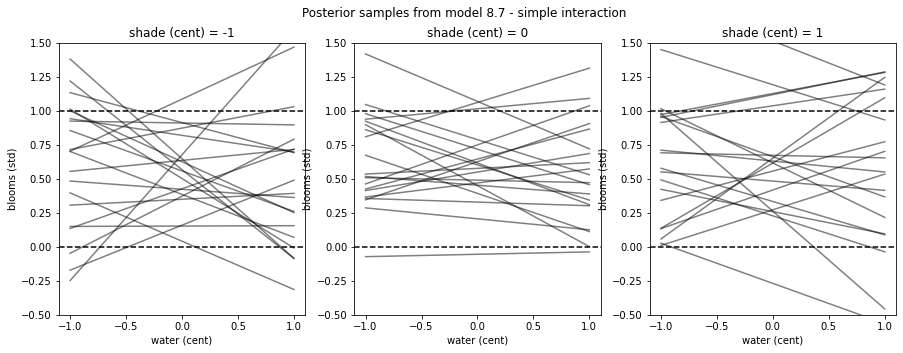

In [217]:
triptych(prior["m8.7"], "8.7 - simple interaction")